In [6]:
from osmread import parse_file, Way,Node,Relation
import shapely.geometry as shpgeo
%pylab inline
import geopandas as gp
from shapely.ops import linemerge
import pandas as pd
import numpy as np
dc_osm = u'D:\★★学习工作\Life in Maryland\Research Project：CyclingSafe\openstreetmap\WashingtonDC.osm'

Populating the interactive namespace from numpy and matplotlib


In [7]:
print datetime.datetime.now()
def get_arr_by_type(etype):
    return {
        Node: nodes,
        Way: ways
    }.get(etype, relations)
nodes, ways, relations = [], [], []
for entity in parse_file(dc_osm):
    array = get_arr_by_type(type(entity))
    array.append(entity)
entities = {}
entities[Node] = nodes
entities[Way] = ways
entities[Relation] = relations
print len(nodes), len(ways), len(relations)     
print datetime.datetime.now()

def build_idx(entitys):
    return {e.id:i for i, e in enumerate(entitys)}
nodes_idx = build_idx(nodes)
ways_idx = build_idx(ways)
relations_idx = build_idx(relations)
entity_idx = {}
entity_idx[Node] = nodes_idx
entity_idx[Way] = ways_idx
entity_idx[Relation] = relations_idx

2016-10-11 19:22:36.630000
2016-10-11 19:24:02.946000


In [13]:
def get_entity(entities, entity_idx, etype, eid):
    idx = entity_idx[etype][eid]
    entity = entities[etype][idx]
    return entity

def node2pt(node):
    return shpgeo.Point(node.lon,node.lat)

def lonlat_in_way(way):
    coors = []
    for nid in way.nodes:
        node = get_entity(entities, entity_idx, Node, nid)
        coors.append((node.lon, node.lat))
    return coors

def way2line(way):
    coors = lonlat_in_way(way)
    return shpgeo.LineString(coors)

def is_highway(way):
    return 'highway' in way.tags

def rltn2poly(relation):
    """
    work for only coninuous lines. if the linestring is not closed, a new line between the first and last node will be added
    """
    cltn = []
    for m in relation.members:
        if m.type==Way:
            way = get_entity(entities, entity_idx, m.type, m.member_id)
            ln = way2line(way)
            cltn.append(ln)
    merged_line = linemerge(cltn)
    return shpgeo.Polygon(merged_line)

In [14]:
r = get_entity(entities, entity_idx, Relation, 162069)
dc_poly = rltn2poly(r)

In [15]:
print datetime.datetime.now()
dc_ways = []
way_with_one_node = []
for way in ways:
    if way.nodes.__len__()>1:
        ln = way2line(way)
        if ln.intersects(dc_poly):
            dc_ways.append(way)
    else:
        way_with_one_node.append(way)
print datetime.datetime.now()

2016-10-11 23:08:55.763000
2016-10-11 23:09:57.767000


In [44]:
dc_ways_df = pd.DataFrame(dc_ways, columns=Way._fields)
dc_ways_df['is_highway'] = dc_ways_df.apply(is_highway,axis=1)
dc_ways_df['geometry']= dc_ways_df.apply(way2line,axis=1)
gp_osmhwy = gp.GeoDataFrame(dc_ways_df[dc_ways_df.is_highway])

# get stsg & bkln

In [18]:
stsg_path = 'dcdata\Street_Segments.geojson'
bkln_path = 'dcdata\Bike_Lane_Street_RightofWay.geojson'
gp_stsg = gp.read_file(stsg_path)
gp_bkln = gp.read_file(bkln_path)

In [19]:
gp_bkln = gp_bkln[['OBJECTID','STREETSEGID','geometry','TRAVELDIRECTION']]
gp_stsg = gp_stsg[['OBJECTID','STREETSEGID','geometry']]

# calc overlap

In [48]:
def get_area_percentage(x):
    area_left = x.geometry_left.area
    area_right = x.geometry.area
    return x.area/area_left if area_left<area_right else x.area/area_right

def get_overlap(left_gdf, right_gdf):
    lgdf_bfr = left_gdf.copy()
    rgdf_bfr = right_gdf.copy()
    lgdf_bfr.geometry = lgdf_bfr.buffer(0.000098)
    rgdf_bfr.geometry = rgdf_bfr.buffer(0.000098)
    jgdf = gp.tools.sjoin(lgdf_bfr, rgdf_bfr, how='left')
    jgdf = jgdf.rename(columns={'geometry':'geometry_left'})
    jgdf_intrsetn = pd.merge(jgdf,rgdf_bfr,left_on='index_right',right_index = True)
    
    jgdf_intrsetn['intersection']=jgdf_intrsetn.apply(lambda x: x.geometry_left.intersection(x.geometry),axis=1)
    jgdf_intrsetn['area'] = jgdf_intrsetn['intersection'].apply(lambda x: x.area)
    jgdf_intrsetn['area_prcnt'] = jgdf_intrsetn.apply(get_area_percentage, axis=1)
    return jgdf_intrsetn

In [49]:
bk_st_bfr_intrsetn = get_overlap(gp_bkln,gp_stsg)
bk_st_ovlp = bk_st_bfr_intrsetn[bk_st_bfr_intrsetn.area_prcnt>0.9]

In [51]:
st_osm_bfr_intrsetn = get_overlap(gp_stsg, gp_osmhwy)

-0.1 13518 80770
0.0 13518 80770
0.1 13516 60469
0.2 13505 35056
0.3 13498 26408
0.4 13485 21983
0.5 13444 18891
0.6 13376 16884
0.7 13209 15319
0.8 12808 13930
0.9 12243 12947


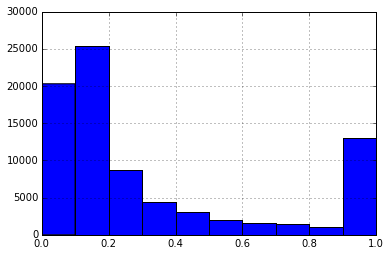

In [83]:
selected_columns = [u'OBJECTID', u'STREETSEGID', u'geometry_left', u'index_right',
                    u'id_x', u'tags_x', u'is_highway_x', u'geometry', u'intersection', u'area', u'area_prcnt']
st_osm_bfr_intrsetn = st_osm_bfr_intrsetn[selected_columns]
st_osm_bfr_intrsetn.area_prcnt.hist()
for i in range(-1,10):
    print i*0.1, st_osm_bfr_intrsetn[st_osm_bfr_intrsetn.area_prcnt>i*0.1].OBJECTID.value_counts().value_counts().sum(),
    print st_osm_bfr_intrsetn[st_osm_bfr_intrsetn.area_prcnt>i*0.1].OBJECTID.value_counts().sum()

In [107]:
def get_ovlp_unmatched_by_areaprcnt(gp_stsg, st_osm_bfr_intrsetn, thres):
    st_osm_ovlp = st_osm_bfr_intrsetn[st_osm_bfr_intrsetn.area_prcnt>thres]
    objid_ovlp_st = st_osm_ovlp.OBJECTID.value_counts().index.tolist()
    objid_unmatched_st = set(gp_stsg.OBJECTID.tolist()) - set(objid_ovlp_st)
    return st_osm_ovlp, objid_unmatched_st

st_osm_ovlp, objid_unmatched_st = get_ovlp_unmatched_by_areaprcnt(gp_stsg, st_osm_bfr_intrsetn, 0.9)

In [103]:
st_osm_ovlp.OBJECTID.value_counts().value_counts().sum()

12243L

In [104]:
len(gp_stsg.OBJECTID), len(objid_ovlp_st), len(set(gp_stsg.OBJECTID.tolist()) - set(objid_ovlp_st))

(13522, 12243, 1279)

In [96]:
gp_osmhwy['color']='#555'

In [109]:
with open('in .js', 'w') as f:
    f.write('var dc = %s; \n' % gp.GeoDataFrame([dc_poly],columns=['geometry']).to_json())
    
    st_osm_ovlp, objid_unmatched_st = get_ovlp_unmatched_by_areaprcnt(gp_stsg, st_osm_bfr_intrsetn, 0.9)
    gp_stsg['color'] = '#FF0000'
    f.write('var stsg = %s; \n' % gp_stsg[gp_stsg.OBJECTID.isin(objid_unmatched_st)].to_json()) 
    
    st_osm_ovlp, objid_unmatched_st = get_ovlp_unmatched_by_areaprcnt(gp_stsg, st_osm_bfr_intrsetn, 0.8)
    gp_stsg['color'] = '#00FF00'
    f.write('var stsg8 = %s; \n' % gp_stsg[gp_stsg.OBJECTID.isin(objid_unmatched_st)].to_json()) 
    
    st_osm_ovlp, objid_unmatched_st = get_ovlp_unmatched_by_areaprcnt(gp_stsg, st_osm_bfr_intrsetn, 0.6)
    gp_stsg['color'] = '#0000FF'
    f.write('var stsg6 = %s; \n' % gp_stsg[gp_stsg.OBJECTID.isin(objid_unmatched_st)].to_json()) 
    
    f.write('var highways = %s;'% gp_osmhwy[['id','geometry','color']].to_json()) 

In [99]:
gp_stsg[gp_stsg.OBJECTID.isin(objid_unmatched_st)]
gp_osmhwy

,id,version,changeset,timestamp,uid,tags,nodes,is_highway,geometry,color
0,4681186,4,28269235,1421734870,24440,{u'highway': u'residential'},"(1391829849, 281072, 3299878446, 3299878455, 2...",True,"LINESTRING (-77.10826059999999 38.935738, -77....",#555
3,4725152,4,9413560,1317151506,207745,{u'source:HFCS': u'District of Columbia (DC GI...,"(649840226, 649840253, 649840259, 649840263, 6...",True,"LINESTRING (-76.9386616 38.8891714, -76.938377...",#555
4,4725153,6,32041113,1434590610,85673,"{u'lanes': u'1', u'highway': u'primary_link', ...","(1484269578, 649840188, 649840192, 649840197, ...",True,"LINESTRING (-76.9376008 38.8898952, -76.937906...",#555
5,5967457,7,37676403,1457391156,3090588,"{u'tiger:name_base': u'Cedar', u'name': u'Ceda...","(3798943074, 4046741774, 49161023, 49161025, 4...",True,"LINESTRING (-77.0803617 38.964959, -77.0808612...",#555
6,5968135,3,14830029,1359424729,451693,"{u'tiger:name_base': u'Summerfield', u'name': ...","(49167033, 49167034, 49167035, 49167037, 49768...",True,"LINESTRING (-77.071907 38.973976, -77.071556 3...",#555
7,5969679,17,37992298,1458627598,85673,"{u'tiger:name_base': u'Brookville', u'maxspeed...","(3657251446, 49183953, 49177919, 49183955, 491...",True,"LINESTRING (-77.07585159999999 38.9685065, -77...",#555
8,5969757,4,36582277,1452811739,3090588,"{u'tiger:name_base': u'Allan', u'name': u'Alla...","(49160809, 3946841404, 937305437)",True,"LINESTRING (-77.099327 38.951797, -77.09868710...",#555
9,5970388,4,33580822,1440531455,1679,"{u'tiger:name_base': u'Holly', u'lanes': u'2',...","(49190879, 49190880, 49190882, 49190883, 33666...",True,"LINESTRING (-77.017242 38.977333, -77.01660099...",#555
10,5971101,3,36582359,1452812132,3090588,"{u'tiger:name_base': u'Berkley', u'name': u'Be...","(49198976, 3946847552, 49198977, 49198978)",True,"LINESTRING (-77.0976082 38.9514986, -77.098034...",#555
11,5971411,5,32726110,1437271593,85673,"{u'tiger:name_base': u'Kirkside', u'name': u'K...","(1387045610, 49202706, 49202707, 49152863, 492...",True,"LINESTRING (-77.082168 38.963573, -77.08307600...",#555
